In [3]:
### Loading and defining important functions

In [4]:
# # INTERMEDIATE RESULTS FROM LOGS

# import json
# import re

# results = []
# with open('../data/experiment_results/dump_intermediate_blended_test.txt') as f:
#     for line in f:
#         if rgx_match := re.search("Results {(.)+}", line):
#             res = rgx_match.group(0)[8:].replace("\'", "\"")
#             res_dict = json.loads(res)
#             results.append(res_dict)
# res = pd.DataFrame.from_records(results)
# res['nll_diff'] = res['nll_learned'] - res['nll_source']
# res = res[res['repetition'] < 16]
# res

In [29]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

def plot_nlld(res: pd.DataFrame, source: str, case: str, ax, col: str=None):
    # Filter results by source name and experiment case, group by training data length, aggregate by regular statistics
    grouped = res.query(f"name=='{source}' & case=='{case}'").groupby(['seqlength'])[['nll_diff']].agg(['min', 'mean', 'std', 'max']).reset_index()

    # Plot min, max, mean+-std
    ax.plot(grouped['seqlength'], grouped['nll_diff']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['nll_diff']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['nll_diff']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['nll_diff']['mean'] - grouped['nll_diff']['std'],
                    grouped['nll_diff']['mean'] + grouped['nll_diff']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')
    
    if "gmm" not in case: ax.set_ylabel(r'$\Delta \hat{H}$')
    try:
        title_app = f" ({case.split("_")[1]} memberships)"
    except IndexError:
        title_app = ''
    ax.set_title(f'NLL Difference' + title_app)
    ax.legend(loc='upper right')

def plot_kl(res: pd.DataFrame, source: str, case: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='{case}'").groupby(['seqlength'])[['kl_divergence']].agg([
        ('min', 'min'),
        ('q25', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q75', lambda x: x.quantile(0.75)),
        ('max', 'max')
    ]).reset_index()
    
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['median'], c=col, label='q25 to q75')
    ax.fill_between(grouped['seqlength'],
                    grouped['kl_divergence']['q25'],
                    grouped['kl_divergence']['q75'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    ax.set_ylim([0, ylims[1]])
    if "gmm" not in case: ax.set_ylabel(r'$KL$')

    try:
        title_app = f" ({case.split("_")[1]} memberships)"
    except IndexError:
        title_app = ''
    ax.set_title(f'KL Divergence' + title_app)
    ax.legend(loc='upper right')

def plot_gmm_nll(res: pd.DataFrame, source: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='blended_gmm'").groupby(['seqlength'])[['nll_gmm', 'l2_gmm']].agg(['min', 'mean', 'std', 'max']).reset_index()

    col = 'red'
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['nll_gmm']['mean'] - grouped['nll_gmm']['std'],
                    grouped['nll_gmm']['mean'] + grouped['nll_gmm']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    # ax.set_ylim([0, ylims[1]])
    ax.set_ylabel(r'$NLL$')
    
    ax.set_title(f'NLL for best GMM')
    ax.legend(loc='upper right')

def plot_gmm_l2(res: pd.DataFrame, source: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='blended_gmm'").groupby(['seqlength'])[['nll_gmm', 'l2_gmm']].agg(['min', 'mean', 'std', 'max']).reset_index()

    col = 'royalblue'
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['l2_gmm']['mean'] - grouped['l2_gmm']['std'],
                    grouped['l2_gmm']['mean'] + grouped['l2_gmm']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    ax.set_ylim([0, ylims[1]])
    ax.set_ylabel(r'$L^2$')
    
    ax.set_title(f'L2 for best GMM')
    ax.legend(loc='upper right')

def plot_best_minmaxmeansd(res_best: pd.DataFrame, name: str, case: str, target: str, col: str=None, ax=None):
    try:
        title_app = f"{case.split("_")[1]}"
    except IndexError:
        title_app = case
    
    bch = res_best.query(f"name=='{name}' & case=='{case}'").reset_index(level='seqlength', drop=False)
    ax.plot(bch['seqlength'], bch[(target, 'mean')], c=col)
    ax.fill_between(bch['seqlength'],
                    bch[(target, 'mean')] - bch[(target, 'std')],
                    bch[(target, 'mean')] + bch[(target, 'std')],
                    alpha=0.1, color=col,
                    label=f"${name}$ {title_app}")
    ax.set_xscale('log')
    ax.set_xlim([bch['seqlength'].min(), bch['seqlength'].max()])
    ax.set_xlabel('Training sequence length')
    
    ax.set_ylabel(target)
    # ylims = ax.get_ylim()
    # ax.set_ylim([
    #     min(bch[(target, 'min')].min(), ylims[0]),
    #     max(bch[(target, 'max')].max(), ylims[1])
    # ])

In [27]:
# Discrete Valued Results

In [ ]:
res_disc = pd.read_csv('../data/experiment_results/experiment_discrete_all_results_2.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_disc['nll_diff'] = res_disc['nll_learned'] - res_disc['nll_source']
# res_disc

In [ ]:
fig = plt.figure(figsize=(9, 5), layout='constrained')
subfigs = fig.subfigures(1, 2, wspace=0.05)
subfigs = subfigs.flatten()

axs = subfigs[0].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[0].suptitle(r'Metrics for learned discrete models approximating $S_3$')
plot_nlld(res_disc, 'S_3', 'discrete', axs[0], col='orange')
plot_kl(res_disc, 'S_3', 'discrete', axs[1], col='blue')

axs = subfigs[1].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[1].suptitle(r'Metrics for learned discrete models approximating $S_5$')
plot_nlld(res_disc, 'S_5', 'discrete', axs[0], col='orange')
plot_kl(res_disc, 'S_5', 'discrete', axs[1], col='blue')

# plt.savefig('mf/discrete_1_overall.pdf')

plt.show()

In [28]:
### Conditional convergence of learned OOM properties (only for the best learned OOMs, by KL divergence)

In [ ]:
pd.set_option('display.max_columns', None)

res_best_disc = res_disc.copy(deep=True)

res_best_disc = res_best_disc \
.sort_values(['kl_divergence']) \
.groupby(['case', 'name', 'seqlength', 'repetition']) \
.head(1) \
.sort_values(['case']) \
.groupby(['name', 'case', 'seqlength']) \
.agg(['min', 'max', 'mean', 'std']) \
.drop(['repetition', 'nll_source', 'nll_learned', 'steps_fsp', 'cwlen', 'iwlen'], axis=1) \
.sort_index(level=['name', 'case', 'seqlength'], ascending=[True, False, True]) \
[['rankmax', 'd0', 'd1', 'n0', 'n1', 'nll_diff', 'kl_divergence', 'mse']]
# res_best_disc

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(DISC) Dimension difference for best approximator")
plot_best_minmaxmeansd(res_best_disc, 'S_3', 'discrete', 'd1', 'orange', ax)
plot_best_minmaxmeansd(res_best_disc, 'S_5', 'discrete', 'd1', 'blue', ax)
ax.axhline(y=10, c='r', ls='--', label='sources dimension')
ax.legend(loc='upper left')

# plt.savefig('mf/discrete_2_d_diff.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(DISC) NLL difference to source for best approximator")
plot_best_minmaxmeansd(res_best_disc, 'S_3', 'discrete', 'nll_diff', 'blue', ax)
plot_best_minmaxmeansd(res_best_disc, 'S_5', 'discrete', 'nll_diff', 'orange', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/discrete_3_nll_diff.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(DISC) KL divergence for best approximator")
plot_best_minmaxmeansd(res_best_disc, 'S_3', 'discrete', 'kl_divergence', 'blue', ax)
plot_best_minmaxmeansd(res_best_disc, 'S_5', 'discrete', 'kl_divergence', 'orange', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/discrete_4_kl_div.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(DISC) MSE for best approximator")
plot_best_minmaxmeansd(res_best_disc, 'S_3', 'discrete', 'mse', 'blue', ax)
plot_best_minmaxmeansd(res_best_disc, 'S_5', 'discrete', 'mse', 'orange', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/discrete_4_mse.pdf')

plt.show()

In [ ]:
plt.figure(figsize=(6, 4))

plt.scatter(np.log2(res_disc[res_disc['name'] == 'S_3']['kl_divergence']),
            res_disc[res_disc['name'] == 'S_3']['nll_learned'],
            marker='^', s=15, facecolors='none', edgecolors='b', alpha=0.4,
            label="$S_3$ approximators metrics")

plt.axhline(res_disc[res_disc['name'] == 'S_3']['nll_source'].mean(),
            c='b', ls='-.', lw=1,
            label="$S_3$ mean source entropy rate")

plt.scatter(np.log2(res_disc[res_disc['name'] == 'S_5']['kl_divergence']),
            res_disc[res_disc['name'] == 'S_5']['nll_learned'],
            marker='s', s=15, facecolors='none', edgecolors='r', alpha=0.4,
            label="$S_5$ approximators metrics")

plt.axhline(res_disc[res_disc['name'] == 'S_5']['nll_source'].mean(),
            c='r', ls='--', lw=1,
            label="$S_5$ mean source entropy rate")

plt.xlabel('$\\log_2$of KL divergence')
plt.ylabel('$\\hat{H}$ (=NLL)')
plt.title("(DISC) NLL for learned OOM against $\\log_2$of KL divergence to source")
plt.legend()

# plt.savefig('mf/discrete_5_oom_nll_oom_kl.pdf')

plt.show()

# Blended Results

In [99]:
res_1 = pd.read_csv('../data/experiment_results/experiment_blended_allFIN_results_1.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_2 = pd.read_csv('../data/experiment_results/experiment_blended_allFIN_results_2.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_2['repetition'] += (res_1['repetition'].max() + 1)
res_3 = pd.read_csv('../data/experiment_results/experiment_blended_allFIN_results_3.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_3['repetition'] += (max(res_2['repetition'].unique()) + 1)
res_4 = pd.read_csv('../data/experiment_results/experiment_blended_allTMP_results_4.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_4['repetition'] += (max(res_3['repetition'].unique()) + 1)
res = pd.concat([res_1, res_2, res_3, res_4])
# n_reps = res['repetition'].max() + 1
# print(n_reps, 'repetitions')
# res = pd.read_csv('../data/experiment_results/experiment_blended_allFIN_results_1.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
n_reps = res['repetition'].max() + 1
print(n_reps, 'repetitions')

15 repetitions


In [100]:
# res.to_csv('../data/experiment_results/experiment_blended_allTMP_results_merged_new.csv')

In [101]:
res['nll_diff'] = res['nll_learned'] - res['nll_source']
# res

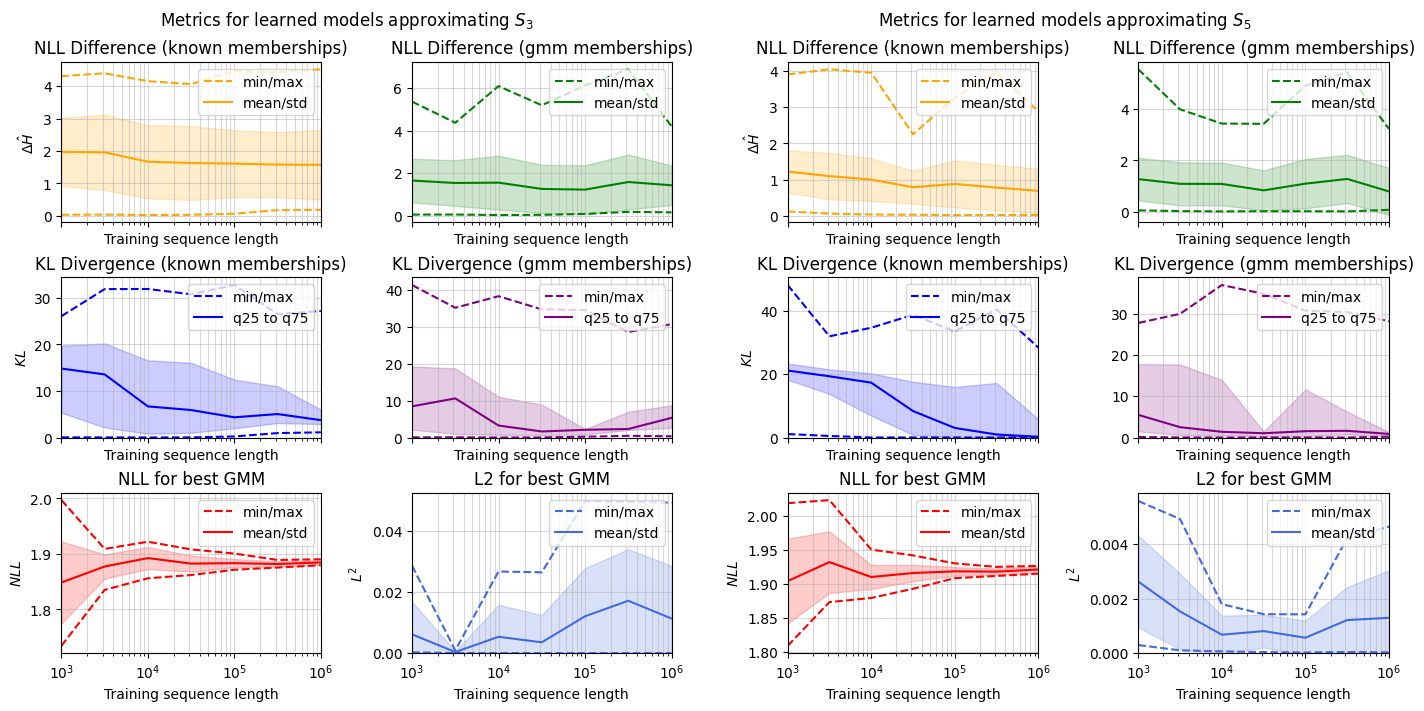

In [102]:
fig = plt.figure(figsize=(14, 7), layout='constrained')
subfigs = fig.subfigures(1, 2, wspace=0.05)
subfigs = subfigs.flatten()

axs = subfigs[0].subplots(3, 2, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[0].suptitle(r'Metrics for learned models approximating $S_3$')
plot_nlld(res, 'S_3', 'blended_known', axs[0], col='orange')
plot_nlld(res, 'S_3', 'blended_gmm', axs[1], col='green')
plot_kl(res, 'S_3', 'blended_known', axs[2], col='blue')
plot_kl(res, 'S_3', 'blended_gmm', axs[3], col='purple')
plot_gmm_nll(res, 'S_3', axs[4])
plot_gmm_l2(res, 'S_3', axs[5])
for ax in axs: ax.grid(True, axis='both', which='both', alpha=0.5, zorder=-1000)

axs = subfigs[1].subplots(3, 2, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[1].suptitle(r'Metrics for learned models approximating $S_5$')
plot_nlld(res, 'S_5', 'blended_known', axs[0], col='orange')
plot_nlld(res, 'S_5', 'blended_gmm', axs[1], col='green')
plot_kl(res, 'S_5', 'blended_known', axs[2], col='blue')
plot_kl(res, 'S_5', 'blended_gmm', axs[3], col='purple')
plot_gmm_nll(res, 'S_5', axs[4])
plot_gmm_l2(res, 'S_5', axs[5])
for ax in axs: ax.grid(True, axis='both', which='both', alpha=0.5, zorder=-1000)

# plt.savefig('mf/blended_many.pdf')
plt.show()

### Conditional convergence of learned OOM properties (only for the best learned OOMs, by KL divergence)

In [103]:
pd.set_option('display.max_columns', None)

res_best = res.copy(deep=True)

res_best = res_best \
.sort_values(['kl_divergence']) \
.groupby(['case', 'name', 'seqlength', 'repetition']) \
.head(1) \
.sort_values(['case']) \
.groupby(['name', 'case', 'seqlength']) \
.agg(['min', 'max', 'mean', 'std']) \
.drop(['repetition', 'nll_source', 'nll_learned', 'steps_fsp', 'cwlen', 'iwlen'], axis=1) \
.sort_index(level=['name', 'case', 'seqlength'], ascending=[True, False, True]) \
[['rankmax', 'd0', 'd1', 'n0', 'n1', 'nll_diff', 'kl_divergence', 'mse', 'nll_gmm', 'l2_gmm']]
# res_best

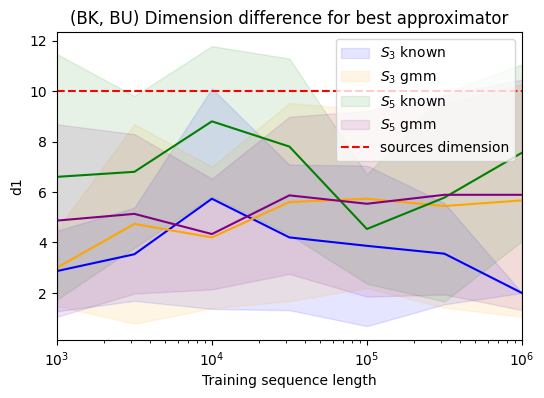

In [104]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK, BU) Dimension difference for best approximator")
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_known', 'd1', 'blue', ax)
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'd1', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_known', 'd1', 'green', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'd1', 'purple', ax)
ax.axhline(y=10, c='r', ls='--', label='sources dimension')
ax.legend(loc='upper right')

# plt.savefig('mf/blended_2_d_diff.pdf')

plt.show()

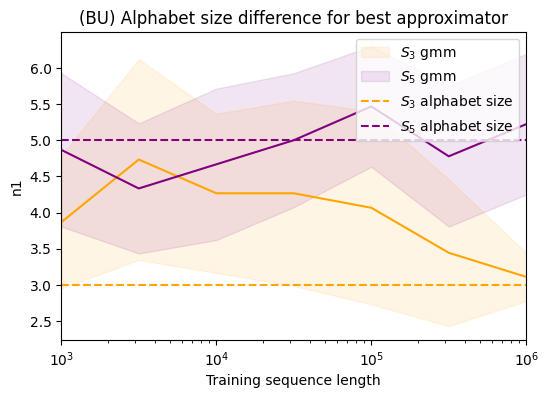

In [105]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BU) Alphabet size difference for best approximator")
# plot_best_minmaxmeansd(res_best, 'S_3', 'blended_known', 'd_diff', 'blue', ax)
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'n1', 'orange', ax)
# plot_best_minmaxmeansd(res_best, 'S_5', 'blended_known', 'd_diff', 'green', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'n1', 'purple', ax)
ax.axhline(y=3, c='orange', ls='--', label='$S_3$ alphabet size')
ax.axhline(y=5, c='purple', ls='--', label='$S_5$ alphabet size')
ax.legend(loc='upper right')

# plt.savefig('mf/blended_3_n_diff.pdf')

plt.show()

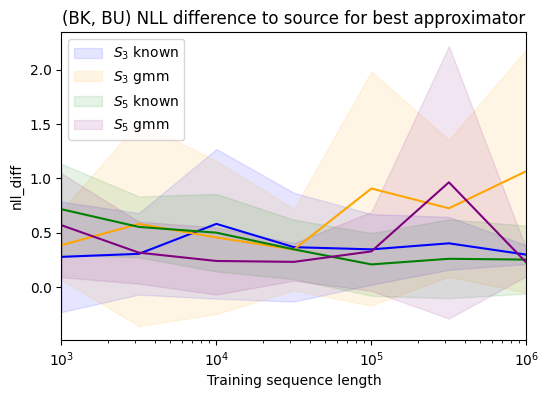

In [106]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK, BU) NLL difference to source for best approximator")
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_known', 'nll_diff', 'blue', ax)
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'nll_diff', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_known', 'nll_diff', 'green', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'nll_diff', 'purple', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/blended_4_nll_diff.pdf')

plt.show()

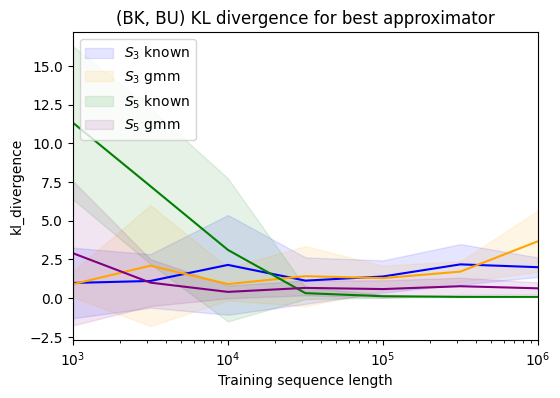

In [107]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK, BU) KL divergence for best approximator")
# plot_kl(res_best, 'S_3', 'blended_known', axs[2], col='blue')
# plot_kl(res_best, 'S_3', 'blended_gmm', axs[2], col='orange')
# plot_kl(res_best, 'S_5', 'blended_known', axs[2], col='green')
# plot_kl(res_best, 'S_5', 'blended_gmm', axs[2], col='purple')
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_known', 'kl_divergence', 'blue', ax)
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'kl_divergence', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_known', 'kl_divergence', 'green', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'kl_divergence', 'purple', ax)
ax.legend(loc='upper left')

plt.savefig('mf/blended_5_kl_div.pdf')

plt.show()

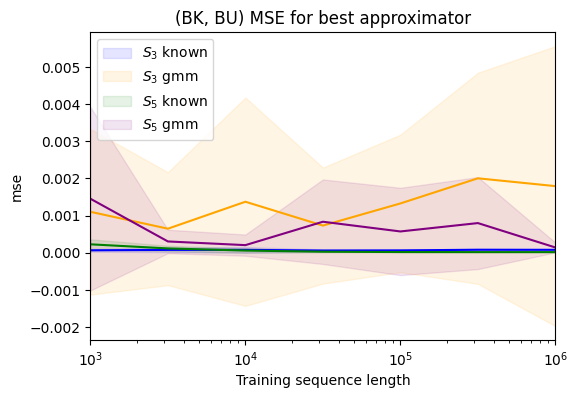

In [108]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK, BU) MSE for best approximator")
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_known', 'mse', 'blue', ax)
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'mse', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_known', 'mse', 'green', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'mse', 'purple', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/blended_5_mse.pdf')

plt.show()

### Conditional convergence of GMM metrics (only for best learned OOMs)

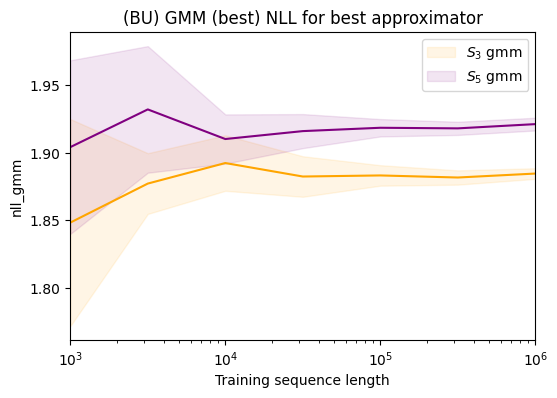

In [109]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BU) GMM (best) NLL for best approximator")
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'nll_gmm', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'nll_gmm', 'purple', ax)
ax.legend(loc='upper right')

# plt.savefig('mf/blended_6_gmm_nll.pdf')

plt.show()

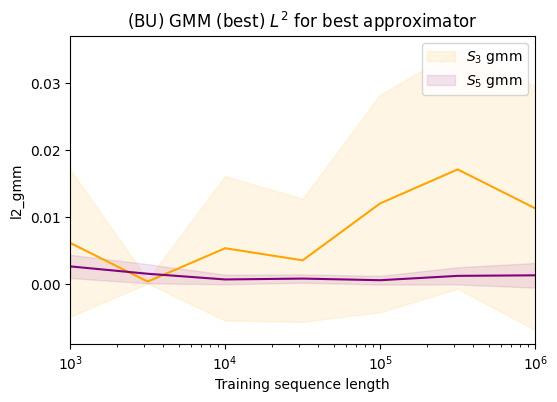

In [110]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BU) GMM (best) $L^2$ for best approximator")
plot_best_minmaxmeansd(res_best, 'S_3', 'blended_gmm', 'l2_gmm', 'orange', ax)
plot_best_minmaxmeansd(res_best, 'S_5', 'blended_gmm', 'l2_gmm', 'purple', ax)
ax.legend(loc='upper right')

# plt.savefig('mf/blended_7_gmm_l2.pdf')

plt.show()

### Comparison of OOM metrics: NLL and KL divergence (trend expected)

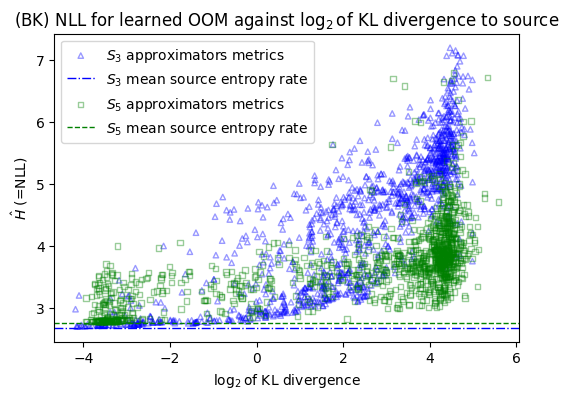

In [111]:
plt.figure(figsize=(6, 4))

plt.scatter(np.log2(res.query("name=='S_3' & case=='blended_known'")['kl_divergence']),
            res.query("name=='S_3' & case=='blended_known'")['nll_learned'],
            marker='^', s=15, facecolors='none', edgecolors='blue', alpha=0.4,
            label="$S_3$ approximators metrics")

plt.axhline(res[res['name'] == 'S_3']['nll_source'].mean(),
            c='blue', ls='-.', lw=1,
            label="$S_3$ mean source entropy rate")

plt.scatter(np.log2(res.query("name=='S_5' & case=='blended_known'")['kl_divergence']),
            res.query("name=='S_5' & case=='blended_known'")['nll_learned'],
            marker='s', s=15, facecolors='none', edgecolors='green', alpha=0.4,
            label="$S_5$ approximators metrics")

plt.axhline(res[res['name'] == 'S_5']['nll_source'].mean(),
            c='green', ls='--', lw=1,
            label="$S_5$ mean source entropy rate")

plt.xlabel('$\\log_2$of KL divergence')
plt.ylabel('$\\hat{H}$ (=NLL)')
plt.title("(BK) NLL for learned OOM against $\\log_2$of KL divergence to source")
plt.legend()

# plt.savefig('mf/discrete_5_oom_nll_oom_kl.pdf')

plt.show()

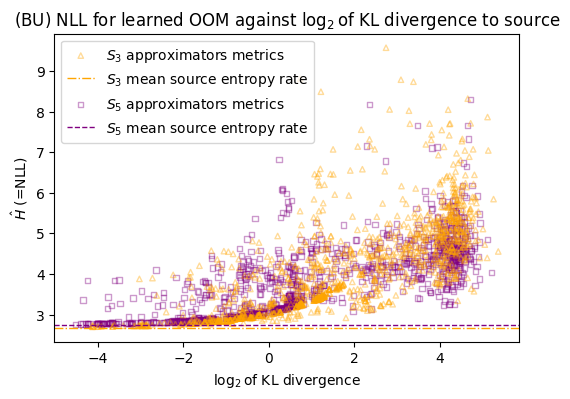

In [112]:
plt.figure(figsize=(6, 4))

plt.scatter(np.log2(res.query("name=='S_3' & case=='blended_gmm'")['kl_divergence']),
            res.query("name=='S_3' & case=='blended_gmm'")['nll_learned'],
            marker='^', s=15, facecolors='none', edgecolors='orange', alpha=0.4,
            label="$S_3$ approximators metrics", zorder=1)

plt.axhline(res[res['name'] == 'S_3']['nll_source'].mean(),
            c='orange', ls='-.', lw=1,
            label="$S_3$ mean source entropy rate")

plt.scatter(np.log2(res.query("name=='S_5' & case=='blended_gmm'")['kl_divergence']),
            res.query("name=='S_5' & case=='blended_gmm'")['nll_learned'],
            marker='s', s=15, facecolors='none', edgecolors='purple', alpha=0.4,
            label="$S_5$ approximators metrics", zorder=0)

plt.axhline(res[res['name'] == 'S_5']['nll_source'].mean(),
            c='purple', ls='--', lw=1,
            label="$S_5$ mean source entropy rate")

plt.xlabel('$\\log_2$of KL divergence')
plt.ylabel('$\\hat{H}$ (=NLL)')
plt.title("(BU) NLL for learned OOM against $\\log_2$of KL divergence to source")
plt.legend()

# plt.savefig('mf/discrete_5_oom_nll_oom_kl.pdf')

plt.show()

## Relationships between GMM and OOM metrics

### Relationship between the NLL and L2 of the best GMMs (inconsequential)

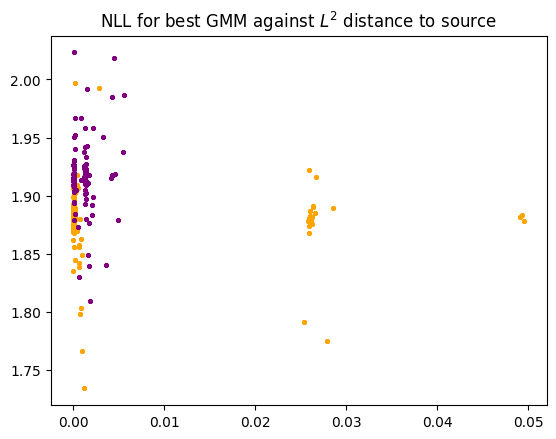

In [113]:
plt.scatter(res.query("name=='S_3'")['l2_gmm'], res.query("name=='S_3'")['nll_gmm'], c='orange', s=5)
plt.scatter(res.query("name=='S_5'")['l2_gmm'], res.query("name=='S_5'")['nll_gmm'], c='purple', s=5)
plt.title("NLL for best GMM against $L^2$ distance to source")

# plt.savefig('mf/blended_8_gmm_nll_gmm_l2.pdf')

plt.show()

### NLL of best GMM compared to the learned OOMs (trend expected, but ideally no trend)

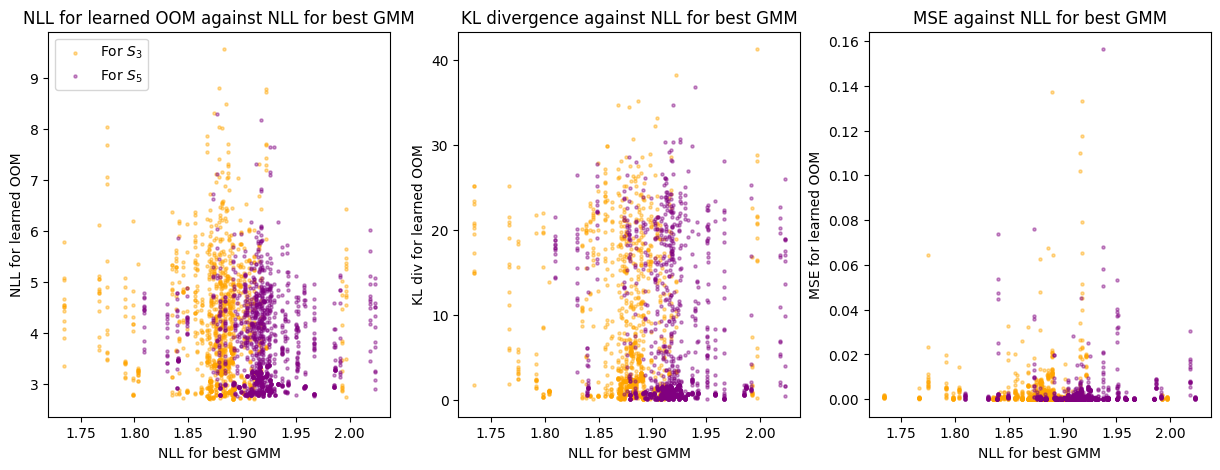

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

axs[0].scatter(res.query("name=='S_3'")['nll_gmm'], res.query("name=='S_3'")['nll_learned'], c='orange', s=5, alpha=0.4, label="For $S_3$")
axs[0].scatter(res.query("name=='S_5'")['nll_gmm'], res.query("name=='S_5'")['nll_learned'], c='purple', s=5, alpha=0.4, label="For $S_5$")
axs[0].set_title("NLL for learned OOM against NLL for best GMM")
axs[0].set_xlabel('NLL for best GMM')
axs[0].set_ylabel('NLL for learned OOM')
axs[0].legend(loc='upper left')

axs[1].scatter(res.query("name=='S_3'")['nll_gmm'], res.query("name=='S_3'")['kl_divergence'], c='orange', s=5, alpha=0.4)
axs[1].scatter(res.query("name=='S_5'")['nll_gmm'], res.query("name=='S_5'")['kl_divergence'], c='purple', s=5, alpha=0.4)
axs[1].set_xlabel('NLL for best GMM')
axs[1].set_ylabel('KL div for learned OOM')
axs[1].set_title("KL divergence against NLL for best GMM")

axs[2].scatter(res.query("name=='S_3'")['nll_gmm'], res.query("name=='S_3'")['mse'], c='orange', s=5, alpha=0.4)
axs[2].scatter(res.query("name=='S_5'")['nll_gmm'], res.query("name=='S_5'")['mse'], c='purple', s=5, alpha=0.4)
axs[2].set_xlabel('NLL for best GMM')
axs[2].set_ylabel('MSE for learned OOM')
axs[2].set_title("MSE against NLL for best GMM")

# plt.savefig('mf/blended_10_between_nll.pdf')
plt.show()

### L2 of best GMM compared to the learned OOMs (trend expected, but ideally no trend)

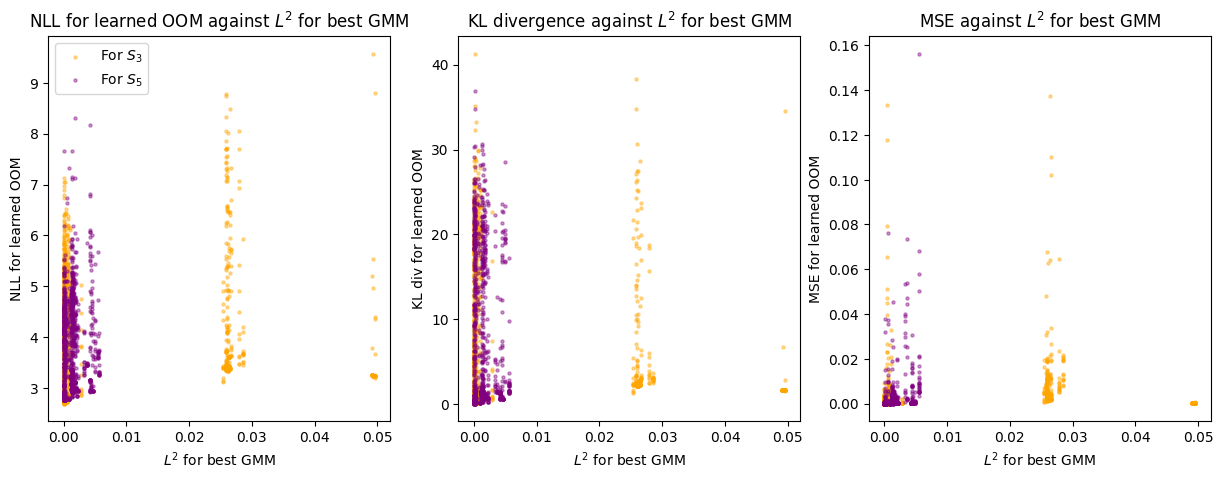

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

axs[0].scatter(res.query("name=='S_3'")['l2_gmm'], res.query("name=='S_3'")['nll_learned'], c='orange', s=5, alpha=0.4, label="For $S_3$")
axs[0].scatter(res.query("name=='S_5'")['l2_gmm'], res.query("name=='S_5'")['nll_learned'], c='purple', s=5, alpha=0.4, label="For $S_5$")
axs[0].set_title("NLL for learned OOM against $L^2$ for best GMM")
axs[0].set_xlabel('$L^2$ for best GMM')
axs[0].set_ylabel('NLL for learned OOM')
axs[0].legend(loc='upper left')

axs[1].scatter(res.query("name=='S_3'")['l2_gmm'], res.query("name=='S_3'")['kl_divergence'], c='orange', s=5, alpha=0.4)
axs[1].scatter(res.query("name=='S_5'")['l2_gmm'], res.query("name=='S_5'")['kl_divergence'], c='purple', s=5, alpha=0.4)
axs[1].set_xlabel('$L^2$ for best GMM')
axs[1].set_ylabel('KL div for learned OOM')
axs[1].set_title("KL divergence against $L^2$ for best GMM")

axs[2].scatter(res.query("name=='S_3'")['l2_gmm'], res.query("name=='S_3'")['mse'], c='orange', s=5, alpha=0.4)
axs[2].scatter(res.query("name=='S_5'")['l2_gmm'], res.query("name=='S_5'")['mse'], c='purple', s=5, alpha=0.4)
axs[2].set_xlabel('$L^2$ for best GMM')
axs[2].set_ylabel('MSE for learned OOM')
axs[2].set_title("MSE against $L^2$ for best GMM")

# plt.savefig('mf/blended_11_between_l2.pdf')
plt.show()

In [77]:
# Blended results (Control)

In [78]:
# res_control_1 = pd.read_csv('../data/experiment_results/experiment_blended_allCONTROL_results_1.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
# res_control_2 = pd.read_csv('../data/experiment_results/experiment_blended_allCONTROL_results_2.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
# res_control_2['repetition'] += (max(res_control_1['repetition'].unique()) + 1)
# res_control = pd.concat([res_control_1, res_control_2])
res_control = pd.read_csv('../data/experiment_results/experiment_blended_allCONTROL_results_1.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)

In [ ]:
# res_control = pd.read_csv('../data/experiment_results/experiment_blended_allCONTROL_results_1.csv', index_col=0).drop(['fsp_source', 'fsp_learned'], axis=1)
res_control['nll_diff'] = res_control['nll_learned'] - res_control['nll_source']
# res_control

In [ ]:
fig = plt.figure(figsize=(8, 6), layout='constrained')
subfigs = fig.subfigures(1, 2, wspace=0.05)
subfigs = subfigs.flatten()

axs = subfigs[0].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[0].suptitle(r'Metrics for learned models approximating $S_3$')
plot_nlld(res_control, 'S_3', 'blended_known', axs[0], col='orange')
plot_kl(res_control, 'S_3', 'blended_known', axs[1], col='blue')

axs = subfigs[1].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[1].suptitle(r'Metrics for learned models approximating $S_5$')
plot_nlld(res_control, 'S_5', 'blended_known', axs[0], col='orange')
plot_kl(res_control, 'S_5', 'blended_known', axs[1], col='blue')

# plt.savefig('mf/blendedCONTROL_many.pdf')
plt.show()

In [26]:
### Conditional convergence of learned OOM properties (only for the best learned OOMs, by KL divergence)

In [ ]:
pd.set_option('display.max_columns', None)

res_control_best = res_control.copy(deep=True)

res_control_best = res_control_best \
.sort_values(['kl_divergence']) \
.groupby(['case', 'name', 'seqlength', 'repetition']) \
.head(1) \
.sort_values(['case']) \
.groupby(['name', 'case', 'seqlength']) \
.agg(['min', 'max', 'mean', 'std']) \
.drop(['repetition', 'nll_source', 'nll_learned', 'steps_fsp', 'cwlen', 'iwlen'], axis=1) \
.sort_index(level=['name', 'case', 'seqlength'], ascending=[True, False, True]) \
[['rankmax', 'd0', 'd1', 'n0', 'n1', 'nll_diff', 'kl_divergence', 'mse']]
# res_best

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK) Dimension difference for best approximator")
plot_best_minmaxmeansd(res_control_best, 'S_3', 'blended_known', 'd1', 'blue', ax)
plot_best_minmaxmeansd(res_control_best, 'S_5', 'blended_known', 'd1', 'green', ax)
ax.axhline(y=10, c='r', ls='--', label='sources dimension')
ax.legend(loc='upper right')

# plt.savefig('mf/blended_control_2_d_diff.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK) NLL difference to source for best approximator")
plot_best_minmaxmeansd(res_control_best, 'S_3', 'blended_known', 'nll_diff', 'blue', ax)
plot_best_minmaxmeansd(res_control_best, 'S_5', 'blended_known', 'nll_diff', 'green', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/blended_control_4_nll_diff.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK) KL divergence to source for best approximator")
plot_best_minmaxmeansd(res_control_best, 'S_3', 'blended_known', 'kl_divergence', 'blue', ax)
plot_best_minmaxmeansd(res_control_best, 'S_5', 'blended_known', 'kl_divergence', 'green', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/blended_control_4_kl_div.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.set_title("(BK) MSE for best approximator")
plot_best_minmaxmeansd(res_control_best, 'S_3', 'blended_known', 'mse', 'blue', ax)
plot_best_minmaxmeansd(res_control_best, 'S_5', 'blended_known', 'mse', 'green', ax)
ax.legend(loc='upper left')

# plt.savefig('mf/blended_control_4_mse.pdf')

plt.show()

In [ ]:
plt.figure(figsize=(6, 4))

plt.scatter(np.log2(res_control.query("name=='S_3' & case=='blended_known'")['kl_divergence']),
            res_control.query("name=='S_3' & case=='blended_known'")['nll_learned'],
            marker='^', s=15, facecolors='none', edgecolors='blue', alpha=0.4,
            label="$S_3$ approximators metrics")

plt.axhline(res_control[res_control['name'] == 'S_3']['nll_source'].mean(),
            c='blue', ls='-.', lw=1,
            label="$S_3$ mean source entropy rate")

plt.scatter(np.log2(res_control.query("name=='S_5' & case=='blended_known'")['kl_divergence']),
            res_control.query("name=='S_5' & case=='blended_known'")['nll_learned'],
            marker='s', s=15, facecolors='none', edgecolors='green', alpha=0.4,
            label="$S_5$ approximators metrics")

plt.axhline(res_control[res_control['name'] == 'S_5']['nll_source'].mean(),
            c='green', ls='--', lw=1,
            label="$S_5$ mean source entropy rate")

plt.xlabel('$\\log_2$of KL divergence')
plt.ylabel('$\\hat{H}$ (=NLL)')
plt.title("(BK) NLL for learned OOM against $\\log_2$of KL divergence to source")
plt.legend()

# plt.savefig('mf/blended_control_5_oom_nll_oom_kl.pdf')

plt.show()